In [1]:
# Mount google drive in colab
from google.colab import drive
drive.mount('/content/drive')

# Connect kaggle in colab
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Set the environment variable for Kaggle API key
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle/'

# Now you can use Kaggle API to download datasets
import kaggle
kaggle.api.authenticate()

# Replace 'username/dataset-name' with the actual dataset you want to download
kaggle.api.dataset_download_files('imperialwarrior/singapore-crypto', unzip=True)


Mounted at /content/drive


# Singaporean Cryptocurrency Analysis using DL

- Dataset from Kaggle [Link](https://www.kaggle.com/datasets/imperialwarrior/singapore-crypto?rvi=1)

### Importing necessary Modules and Libraries

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Different models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


## Reading `metadata.csv` file
- It contains information about the Bit coin Pair Name and Bit Coin Pair Symbol.
- Along with that it also contains the `Filename` of that bitcoin dataset.

In [3]:
df = pd.read_csv('/content/metadata.csv')
print(df.shape)
df.head()

(7537, 3)


,Coin Pair Name,Coin Pair Symbol,Filename
0,Bitcoin SGD,BTC-SGD,BTC-SGD.csv
1,Ethereum SGD,ETH-SGD,ETH-SGD.csv
2,Tether USDt SGD,USDT-SGD,USDT-SGD.csv
3,BNB SGD,BNB-SGD,BNB-SGD.csv
4,USD Coin SGD,USDC-SGD,USDC-SGD.csv


### Reading about basic information of file `metadata.csv` like, unique values corresponding to the different columns.

In [4]:
print(len(df['Coin Pair Name'].unique()))
print(len(df['Coin Pair Symbol'].unique()))
print(len(df['Filename'].unique()))

7474
7537
7537


### Let's see the dataset of index 0 i.e., First dataset

In [5]:
data = pd.read_csv(os.path.join('/content/data/', df['Filename'][0]))
print(f'Unique elements correspond to Name = {len(data["Name"].unique())}')
print(f'Unique elements correspond to Symbol = {len(data["Symbol"].unique())}')
print(f'Shape: ', data.shape)
data.head()

Unique elements correspond to Name = 1
Unique elements correspond to Symbol = 1
Shape:  (3383, 9)


,Name,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
0,Bitcoin SGD,BTC-SGD,2014-09-17,588.148647,591.064995,571.178236,577.379609,577.379609,21056800
1,Bitcoin SGD,BTC-SGD,2014-09-18,579.204817,579.204817,523.731201,538.102924,538.102924,34483200
2,Bitcoin SGD,BTC-SGD,2014-09-19,537.202785,541.930028,487.079011,500.080185,500.080185,37919700
3,Bitcoin SGD,BTC-SGD,2014-09-20,499.924402,536.180566,493.856994,517.950509,517.950509,36863600
4,Bitcoin SGD,BTC-SGD,2014-09-21,516.913098,522.411760,498.034510,505.178603,505.178603,26580100


In [6]:
data.drop(columns=['Name', 'Symbol'], inplace=True)
data.Date = pd.to_datetime(data.Date)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3383 entries, 0 to 3382
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3383 non-null   datetime64[ns]
 1   Open       3383 non-null   float64       
 2   High       3383 non-null   float64       
 3   Low        3383 non-null   float64       
 4   Close      3383 non-null   float64       
 5   Adj Close  3383 non-null   float64       
 6   Volume     3383 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 185.1 KB


### Declaring some global variables after watching the datasets.

In [7]:
filePath = '/content/data/'
target = 'Close'
check = 5
testSize = 0.2

# Training only first 25 Datasets out of 7537 datasets.
limit = 25
models = {
  'Linear Regression': LinearRegression(),
  'Ridge Regression': Ridge(),
  'Random Forest Regressor': RandomForestRegressor(),
  'Decision Tree Regressor': DecisionTreeRegressor(),
  'Gradient Boosting Regressor': GradientBoostingRegressor(),
  'XGBoost Regressor': XGBRegressor(objective ='reg:squarederror')
}

### Function which can plot the graph of the dataset

In [8]:
def plotGraph(data, name):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(data['Date'], data['Open'], label='Open', color='green')
    ax.plot(data['Date'], data['Close'], label='Close', color='red')
    ax.vlines(data['Date'], ymin=data['Low'], ymax=data['High'], color='black', linewidth=1, label='High/Low')

    ax.set_title(name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig(f'{name}.png')

    plt.show()


### Splitting the dataset into training, testing, and validation dataset.

In [9]:
def splitData(dataFrame, testSize=0.2):
  # Preprocessing the datasets
  x = dataFrame[["Open", "High", "Low", "Volume"]]
  y = dataFrame[target]
  x = x.to_numpy()
  y = y.to_numpy()
  y = y.reshape(-1, 1)

  # Split the dataset into training and testing sets using train_test_split
  xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=testSize, random_state=42)

  response = [xtrain, xtest, ytrain, ytest]
  return response


### Function to train the model and return the accuracy to that corresponding dataset.

In [10]:
def trainModel(xtrain, xtest, ytrain, ytest, fileName):
  # Create an empty DataFrame to store accuracy for the current dataset
  datasetAccuracy = pd.DataFrame(columns=['Dataset'] + list(models.keys()))

  # Store the dataset name
  datasetAccuracy['Dataset'] = [fileName]

  for modelName, model in models.items():
    # Fit the model
    model.fit(xtrain, ytrain)

    # Check the accuracy of the model and its forecasting
    score = model.score(xtest, ytest)

    # Store the accuracy in the DataFrame
    datasetAccuracy[modelName] = [score]

  return datasetAccuracy


### Function to train the dataset on all the models and get the accuracies on different models.

In [11]:
def trainModels(dataFrame):
  # Initialize an empty DataFrame to store accuracy results
  accuracyDF = pd.DataFrame(columns=['Dataset'] + list(models.keys()))

  # Iterate over only limited datasets
  for i in dataFrame.index:
    if i >= limit:
      break

    # For a single dataset
    fileName = dataFrame['Filename'][i]
    data = pd.read_csv(os.path.join(filePath, fileName))

    # Let's plot the graph of the ith dataset
    plotGraph(data, fileName[slice(-4)])

    # Split dataset for training and testing purpose
    xtrain, xtest, ytrain, ytest = splitData(data)

    # Now, train the model and get the accuracy of all the models
    datasetAccuracy = trainModel(xtrain, xtest, ytrain, ytest, fileName[slice(-4)])

    # Append the accuracy for the current dataset to the overall DataFrame
    accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)

  return accuracyDF

### Calling the function to train the models on the limited dataset

(because lack of resouces like GPU, RAM, etc.)

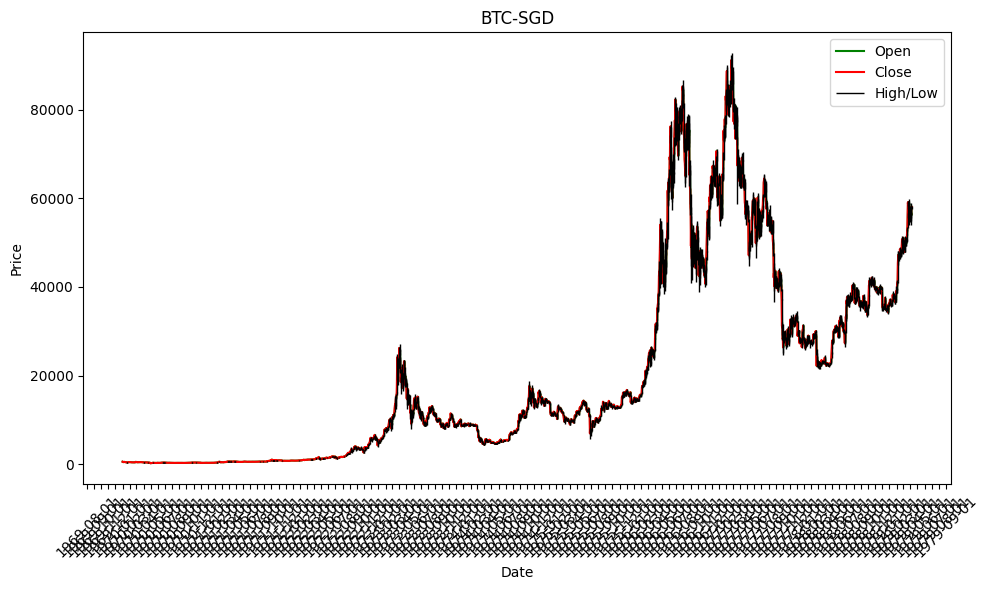

<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


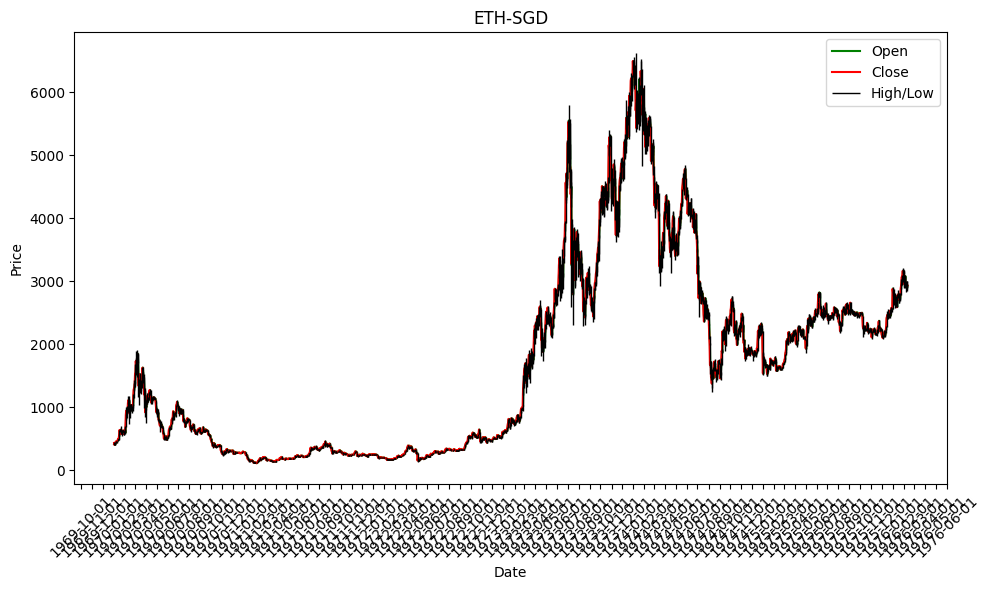

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.46304e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


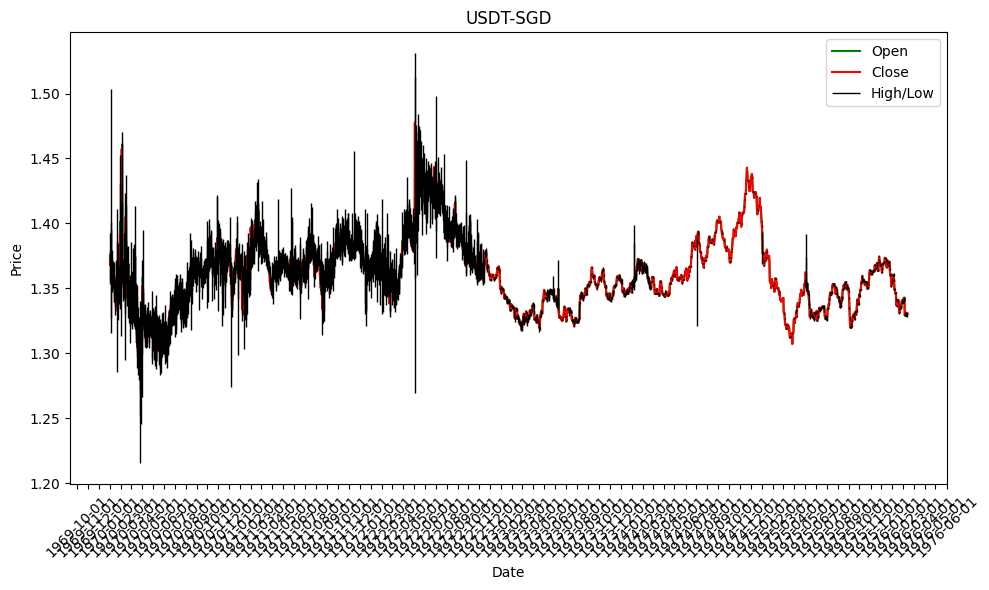

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.02119e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


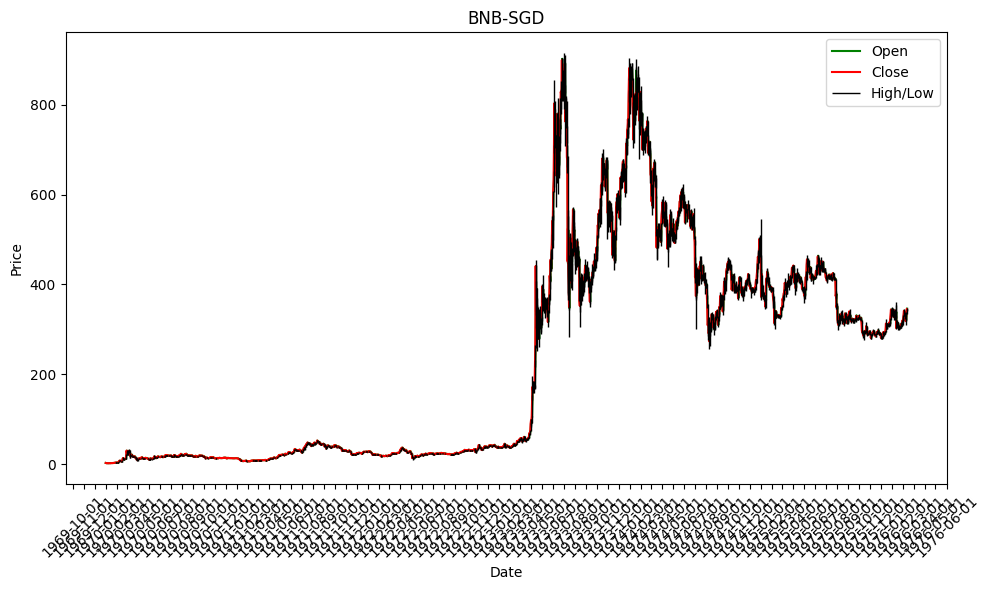

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.3842e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


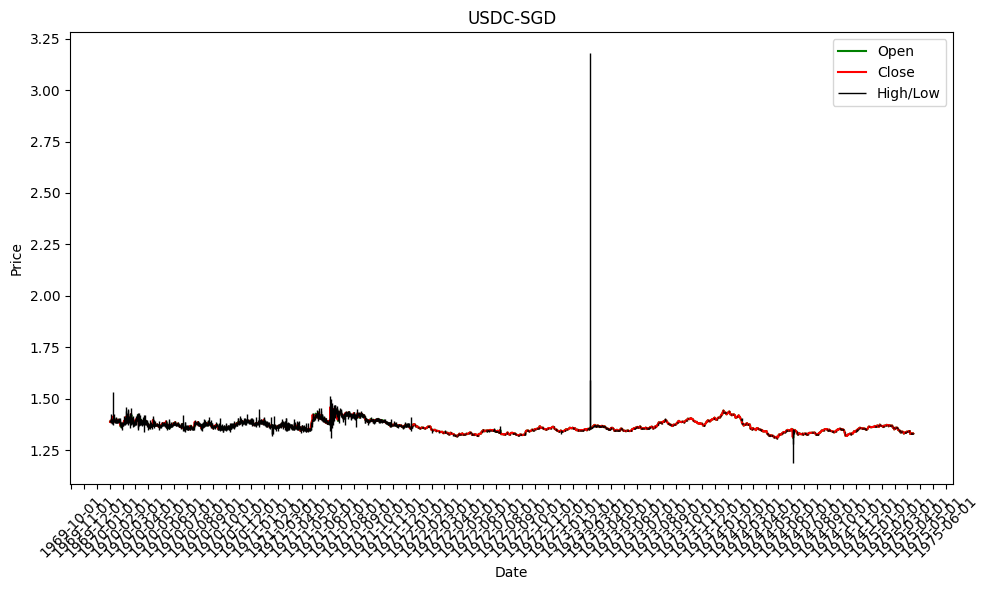

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.60799e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


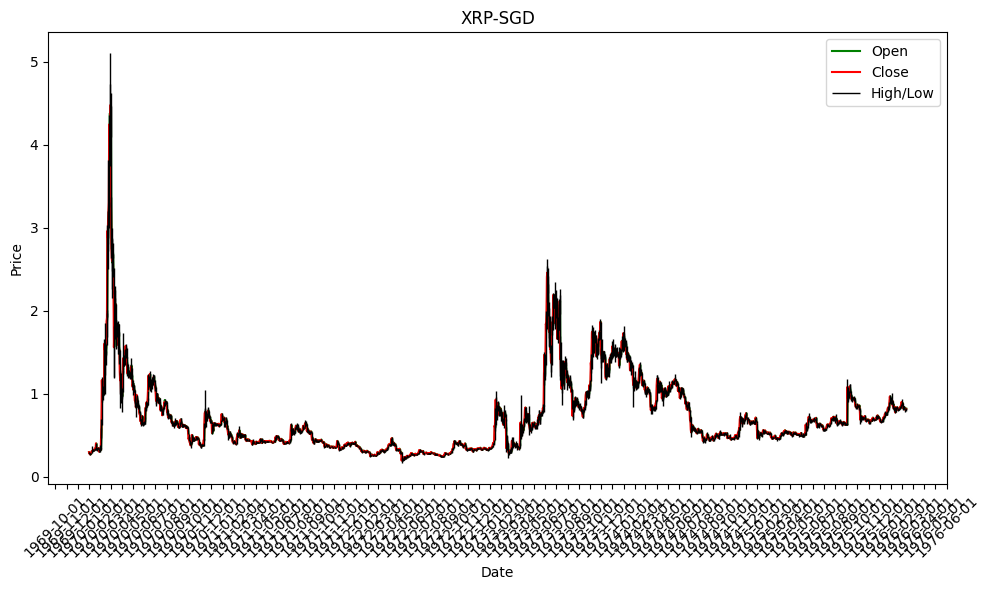

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.44375e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


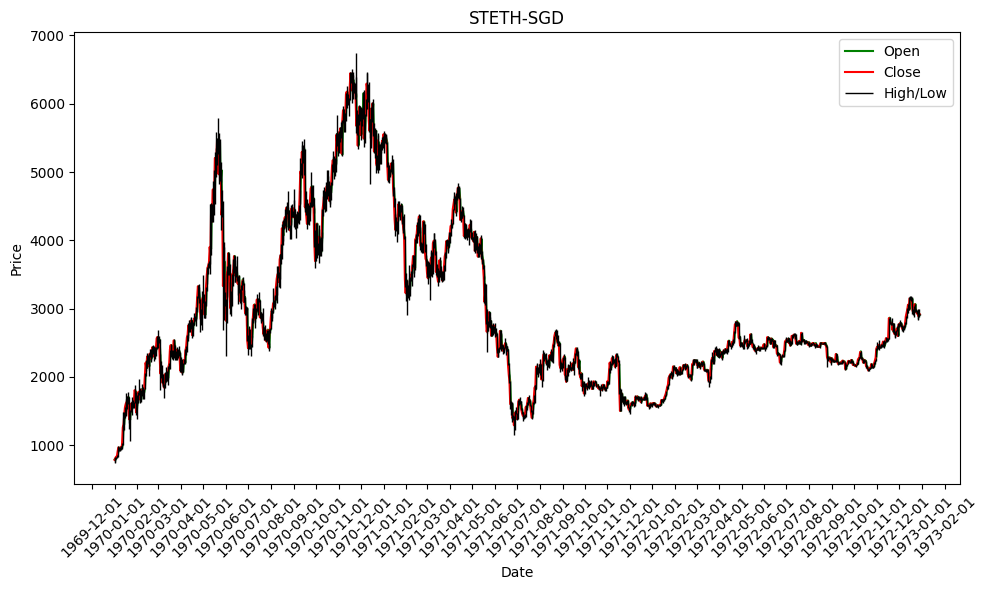

<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


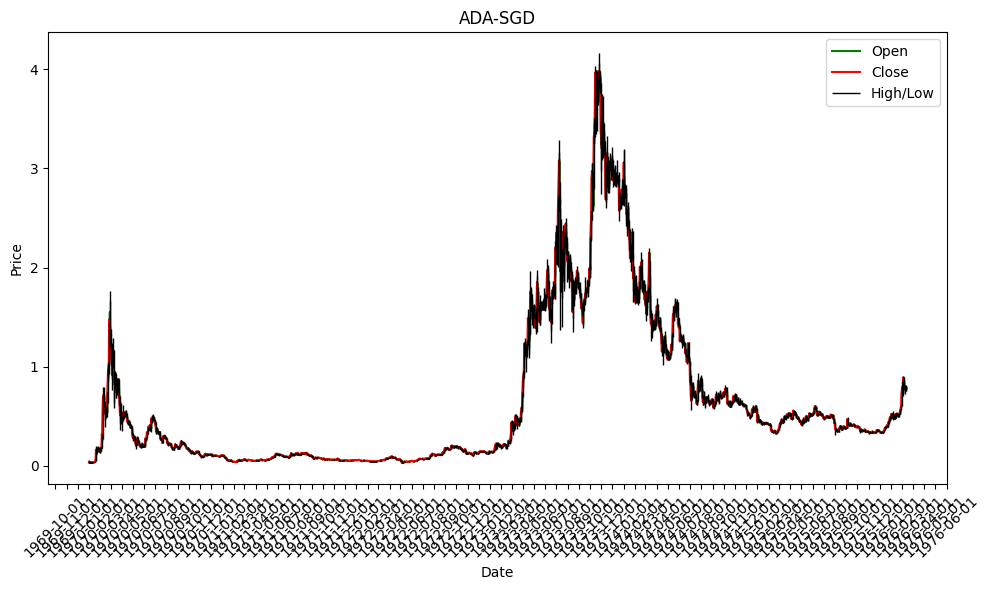

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.05175e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


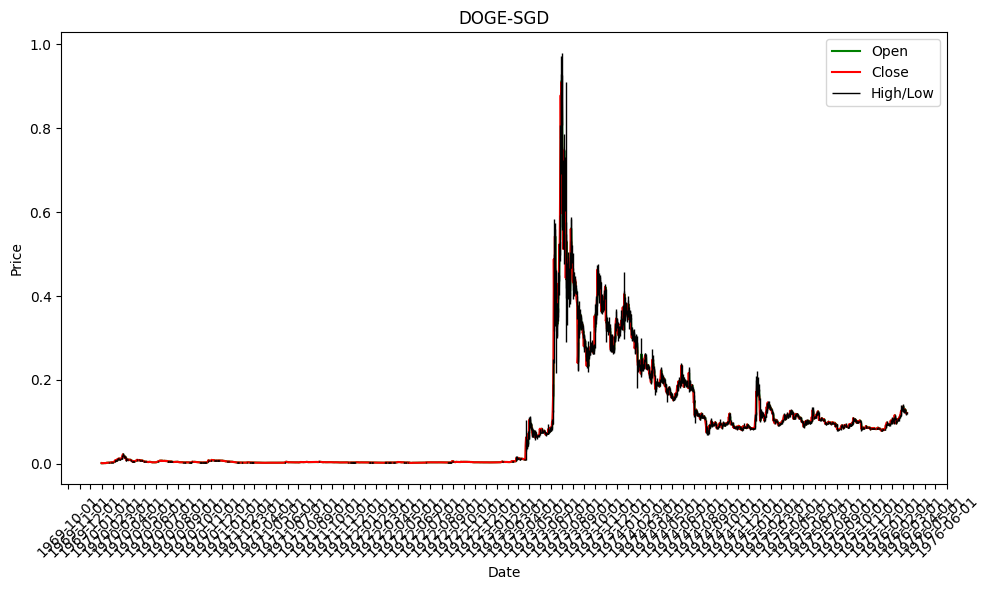

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.04878e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


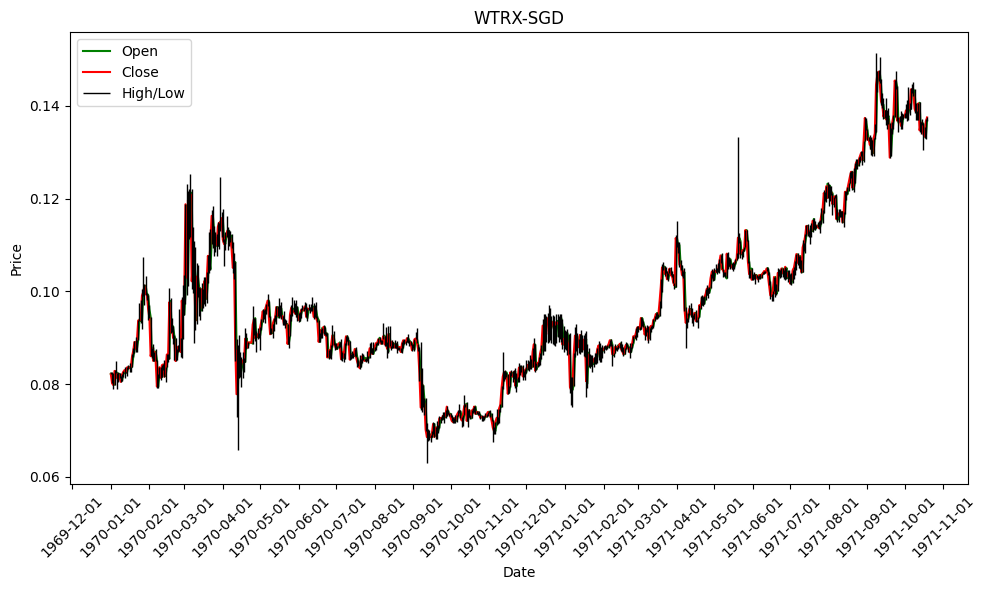

<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


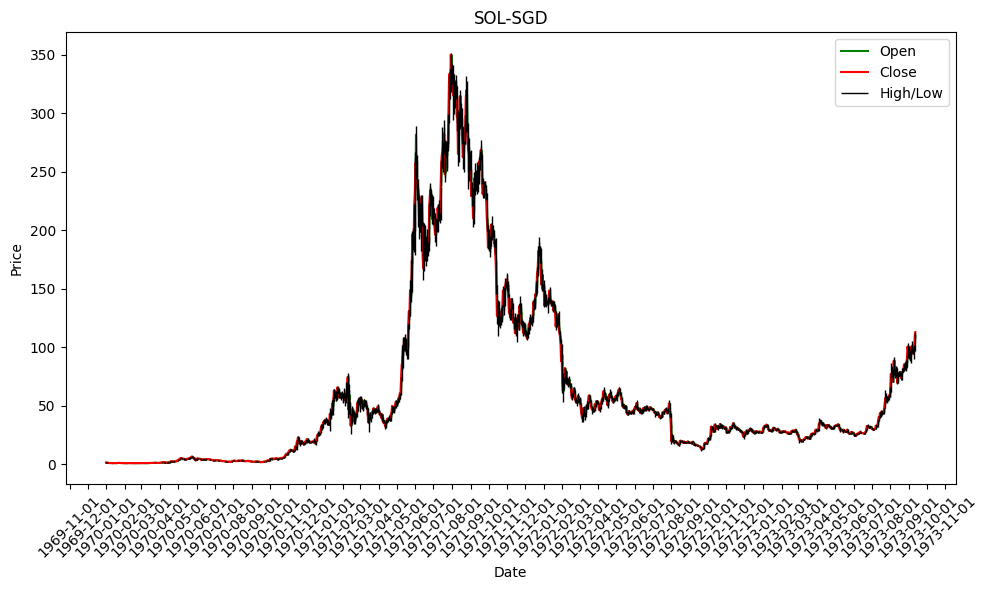

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.68924e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


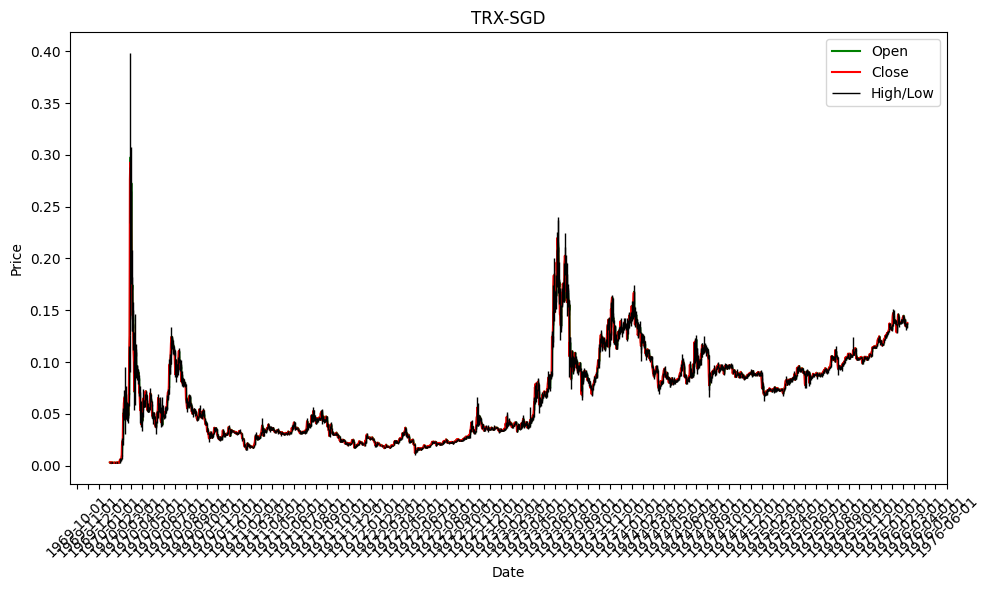

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.67734e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


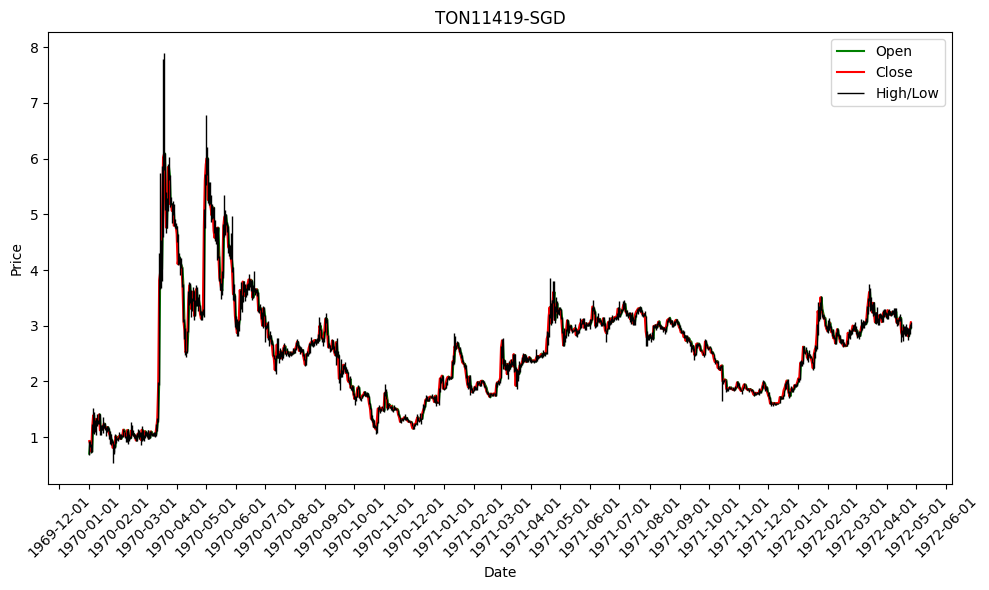

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78396e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


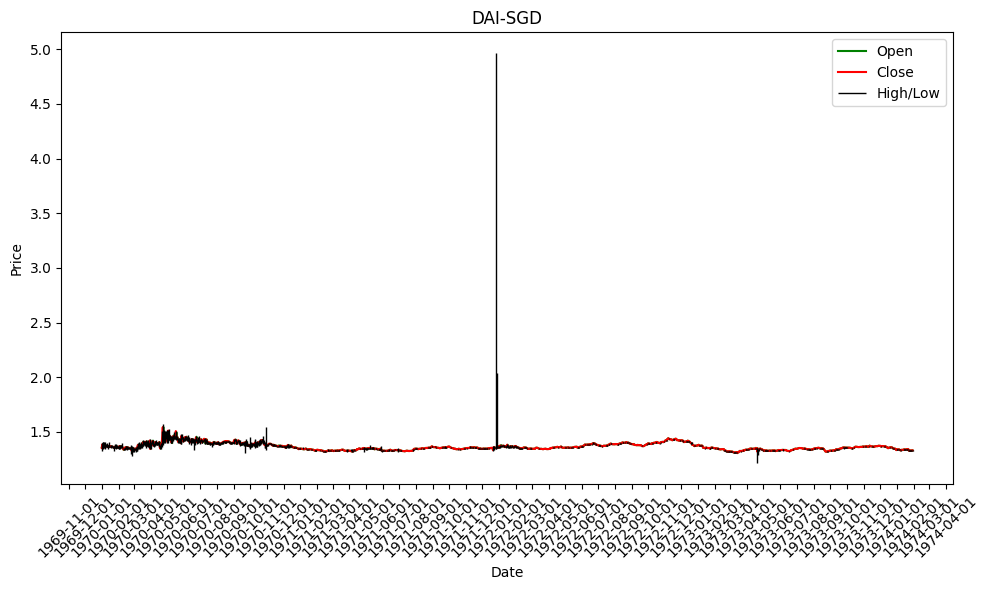

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.07982e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


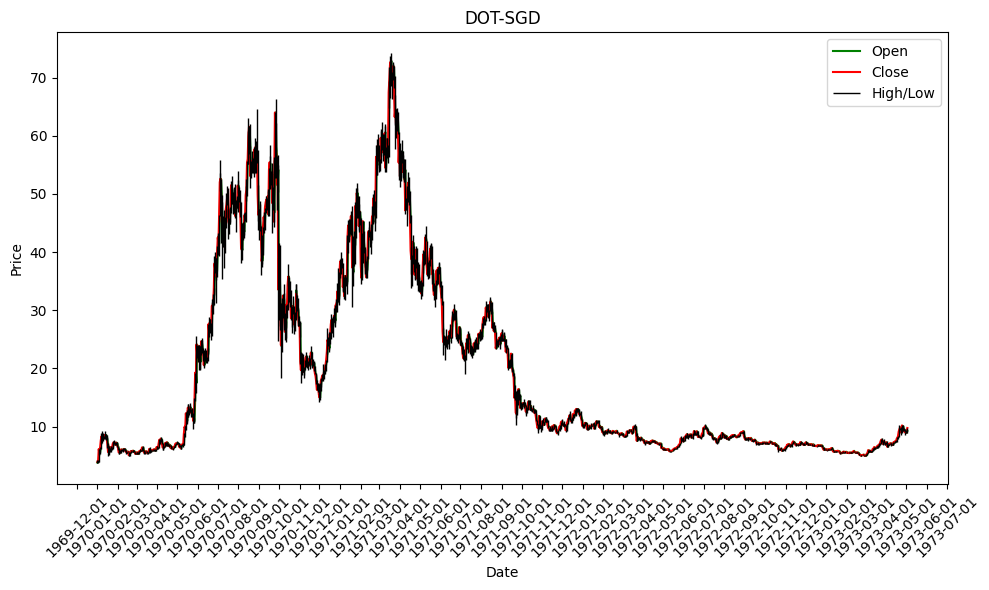

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.94815e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


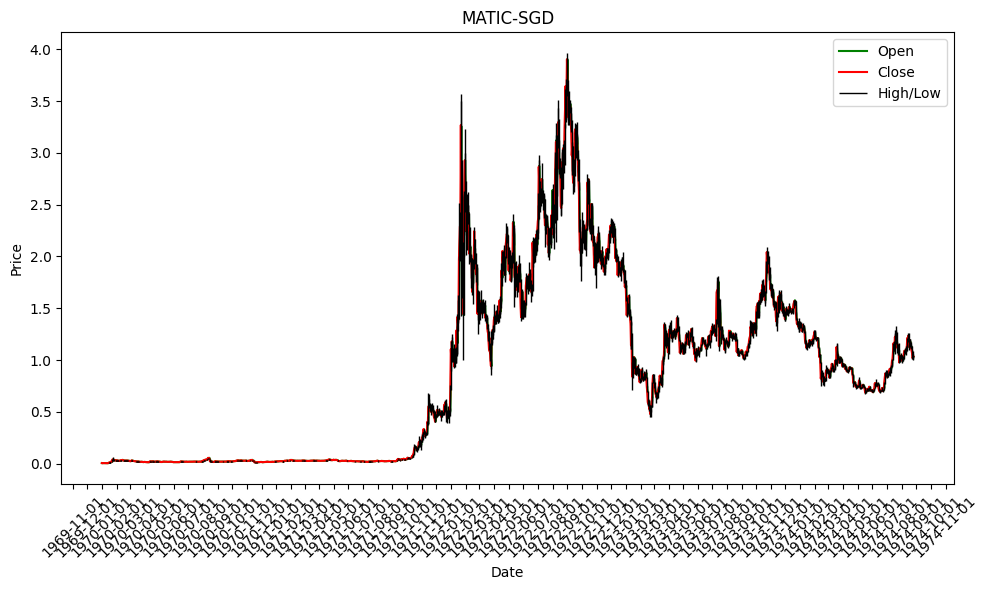

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.89242e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


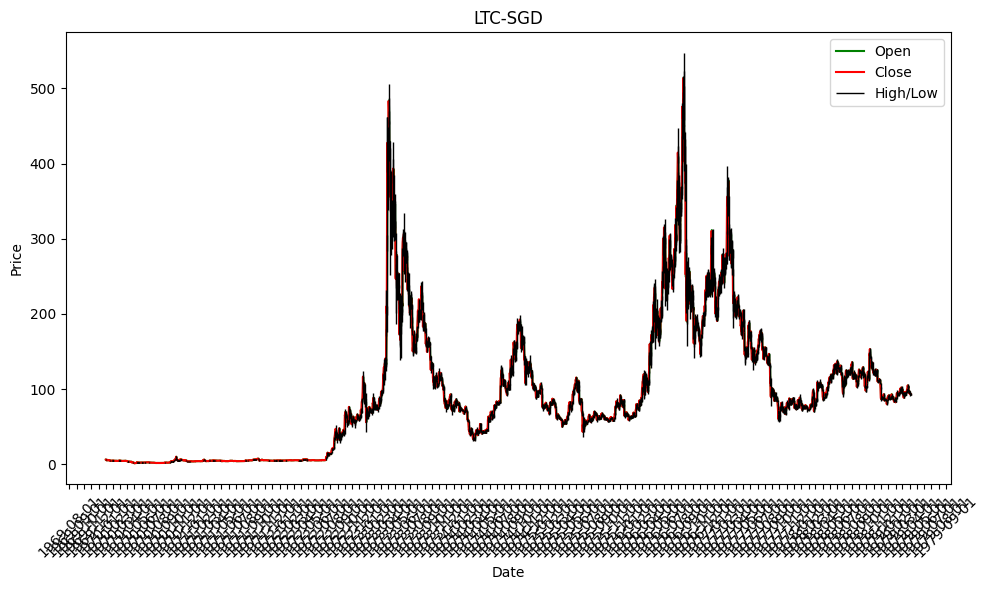

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.89996e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


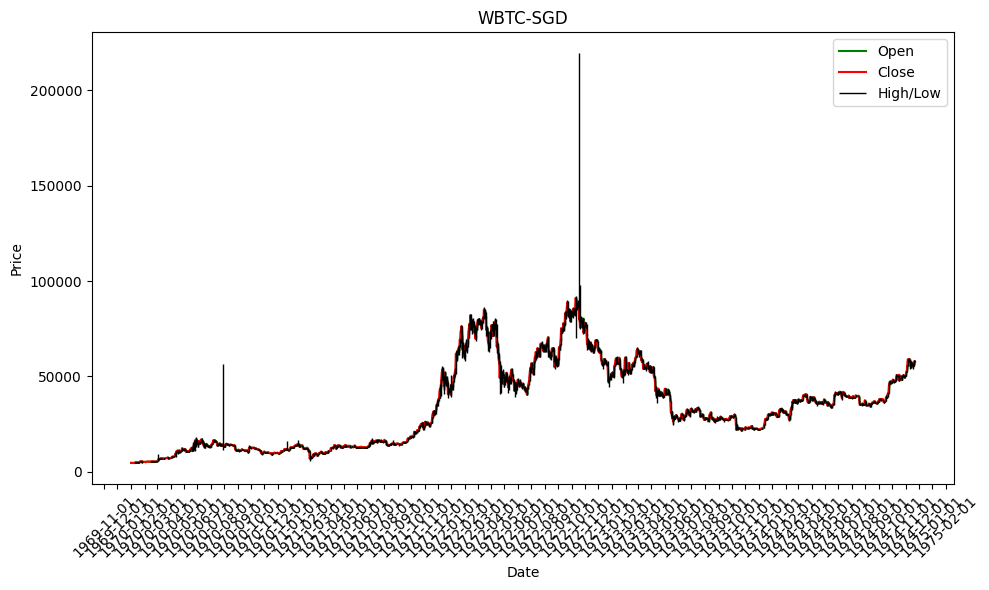

<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


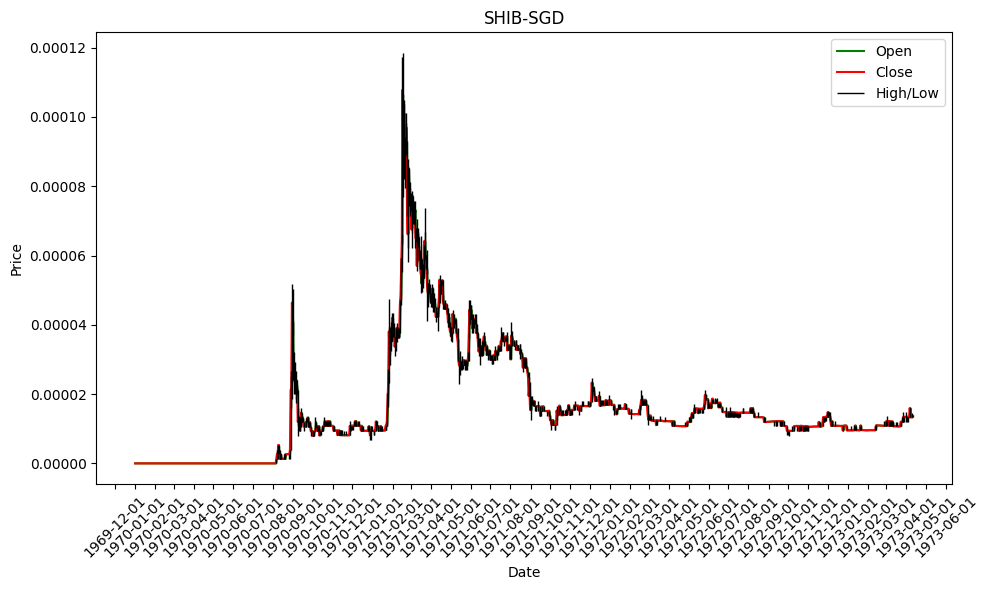

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.63595e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


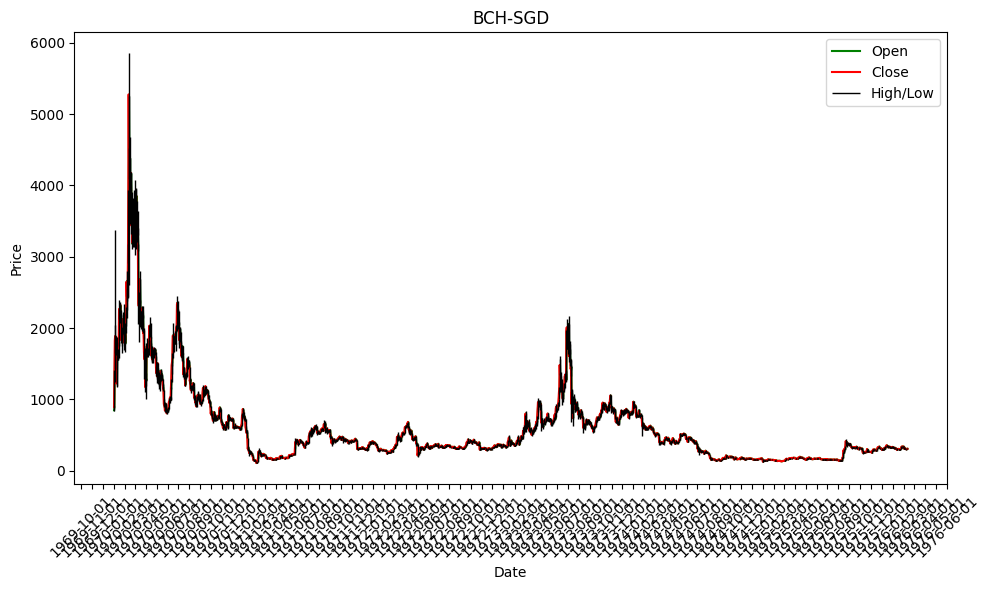

<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


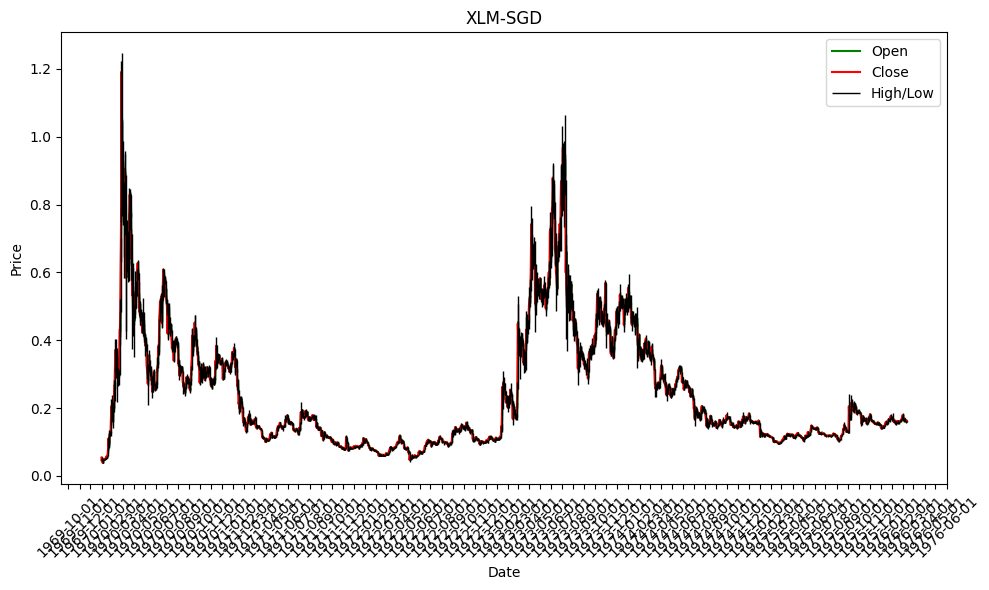

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.29537e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


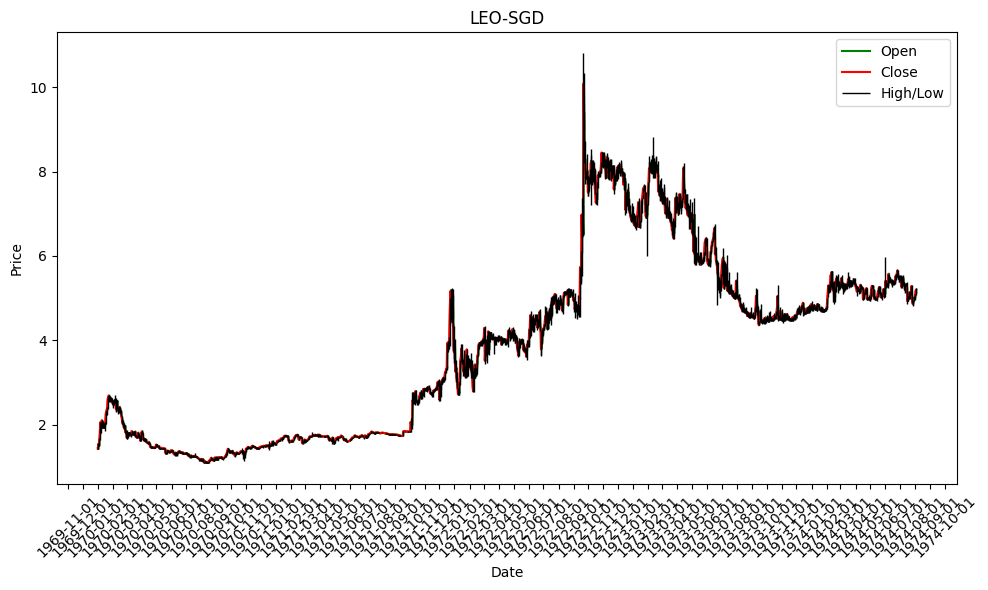

<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


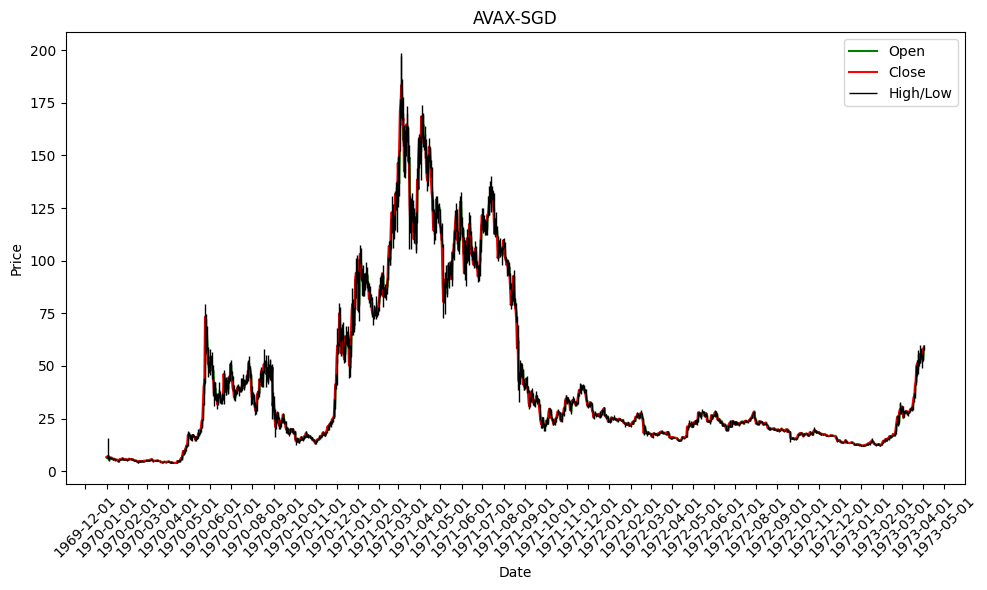

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.59135e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


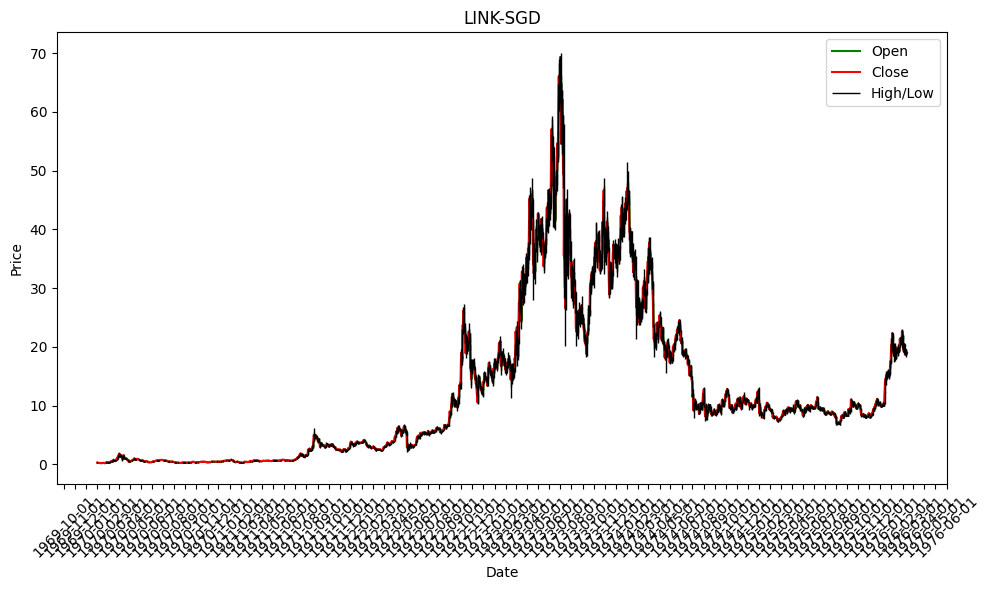

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.48274e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


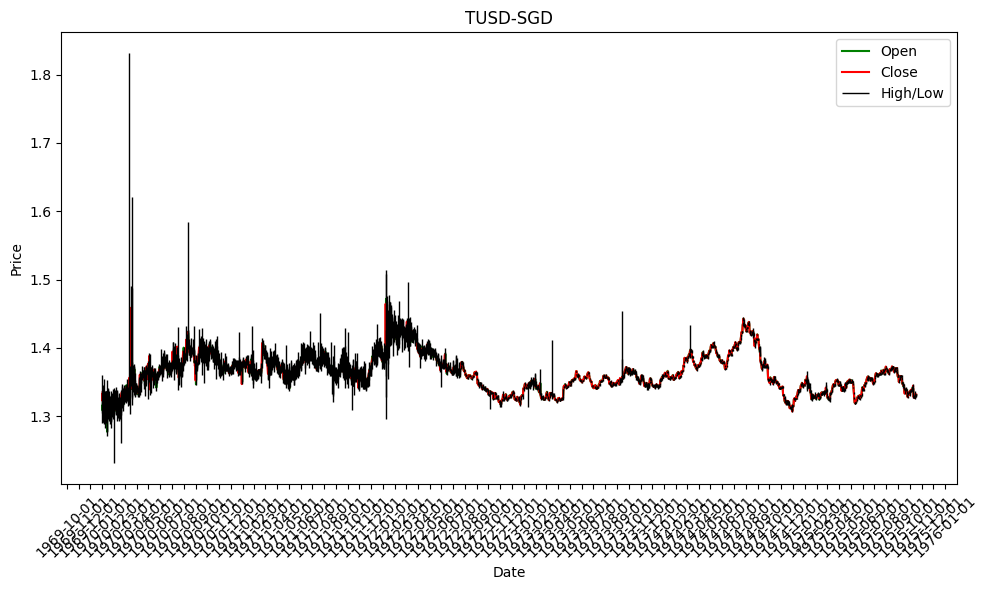

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.12519e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
<ipython-input-10-4521ef8e7de3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-11-830c02f420f3>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append(datasetAccuracy, ignore_index=True)


In [12]:
# Call the trainModels function
accuracies = trainModels(df)

### Save accuracies of the whole training results into a single csv file named `results.csv`

In [13]:
accuracies.to_csv('results.csv', index=False)

### Let us see the saved dataset `results.csv`

In [14]:
resultsData = pd.read_csv('results.csv')
print("Accuracies of Different models on different datasets!")
resultsData

Accuracies of Different models on different datasets!


,Dataset,Linear Regression,Ridge Regression,Random Forest Regressor,Decision Tree Regressor,Gradient Boosting Regressor,XGBoost Regressor
0,BTC-SGD,0.999703,0.999703,0.999471,0.999015,0.999401,0.999357
1,ETH-SGD,0.999311,0.999311,0.998634,0.998103,0.998487,0.998446
2,USDT-SGD,0.973631,0.931483,0.966791,0.953660,0.963711,0.966679
3,BNB-SGD,0.999381,0.999381,0.998796,0.998165,0.998849,0.998626
4,USDC-SGD,0.976592,0.880117,0.980060,0.971069,0.977193,0.979106
5,XRP-SGD,0.986789,0.990231,0.991855,0.986753,0.992090,0.991860
6,STETH-SGD,0.997152,0.997152,0.995454,0.992978,0.995188,0.994591
7,ADA-SGD,0.998844,0.998843,0.998001,0.995902,0.997587,0.997686
8,DOGE-SGD,0.997532,0.996282,0.996539,0.995780,0.996299,0.994917
9,WTRX-SGD,0.993193,0.520164,0.985248,0.973832,0.986284,0.981738


#### Hence, Model training completed, and accuracy of all models on different dataset is stored in the CSV file.

---

## Let's now train the model on LSTM model

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, r2_score


#### Now, prepare the LSTM Neural Network

In [16]:
def lstmNeuralNetwork(shape):
  # LSTM neural network building
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape=(shape, 1)))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))
  model.summary()
  return model


#### Let's train the model and fit the dataset on the model

In [17]:
def lstmTrain(xtrain, ytrain, xtest, ytest, model, epochs=30, batchSize=1):
  # Compile this model and fit the dataset on the model
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(xtrain, ytrain, batch_size=batchSize, epochs=epochs)

  predictions = model.predict(xtest)

  # Calculate Mean Squared Error
  mse = mean_squared_error(ytest, predictions)

  # Calculate R2 Score
  r2 = r2_score(ytest, predictions)

  return {'mse': mse, 'r2': r2}


#### Iterate over all the datasets and fit the on the model and store the accuracy of the model on that corresponding dataset

In [18]:
def lstmModelTrain(dataFrame):
  # Create an empty DataFrame to store accuracy results
  accuracyDF = pd.DataFrame(columns=['Dataset', 'MSE', 'R2'])

  # LSTM model building
  model = lstmNeuralNetwork(4)

  # Iterate over only limited datasets
  for i in dataFrame.index:
    if i >= limit:
      break

    # For a single dataset
    fileName = dataFrame['Filename'][i]
    data = pd.read_csv(os.path.join(filePath, fileName))

    # Split dataset for training and testing purpose
    xtrain, xtest, ytrain, ytest = splitData(data)

    # Now, train the model and get the accuracy of all the models
    accuracy = lstmTrain(xtrain, ytrain, xtest, ytest, model, 20)

    # Append the accuracy for the current dataset to the overall DataFrame
    accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)

  return accuracyDF


### Calling the function to train the models on the limited dataset

(because lack of resouces like GPU, RAM, etc.)

In [19]:
# Call the trainModels function
accuracies = lstmModelTrain(df)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2706/2706 [==============================] - 32s 10ms/step - loss: 738818624.0000
Epoch 2/20
2706/2706 [==============================] - 19s 7ms/step - loss: 514828640.00

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1787/1787 [==============================] - 16s 7ms/step - loss: 24145742.0000
Epoch 2/20
1787/1787 [==============================] - 13s 7ms/step - loss: 2811040.7500
Epoch 3/20
1787/1787 [==============================] - 13s 7ms/step - loss: 807476.5000
Epoch 4/20
1787/1787 [==============================] - 11s 6ms/step - loss: 585970.6250
Epoch 5/20
1787/1787 [==============================] - 12s 7ms/step - loss: 402421.7188
Epoch 6/20
1787/1787 [==============================] - 13s 7ms/step - loss: 436989.6250
Epoch 7/20
1787/1787 [==============================] - 13s 7ms/step - loss: 445874.7500
Epoch 8/20
1787/1787 [==============================] - 12s 7ms/step - loss: 1128725.7500
Epoch 9/20
1787/1787 [==============================] - 12s 7ms/step - loss: 519350.1562
Epoch 10/20
1787/1787 [==============================] - 12s 7ms/step - loss: 410215.4062
Epoch 11/20
1787/1787 [==============================] - 13s 7ms/step - loss: 613061.7500
Epoch 12/20
1787/1787 [===

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1787/1787 [==============================] - 16s 6ms/step - loss: 3223310.0000
Epoch 2/20
1787/1787 [==============================] - 12s 7ms/step - loss: 6.0094
Epoch 3/20
1787/1787 [==============================] - 13s 7ms/step - loss: 2.3053
Epoch 4/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.6071
Epoch 5/20
1787/1787 [==============================] - 12s 7ms/step - loss: 0.2000
Epoch 6/20
1787/1787 [==============================] - 11s 6ms/step - loss: 0.1215
Epoch 7/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.1855
Epoch 8/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.3547
Epoch 9/20
1787/1787 [==============================] - 18s 10ms/step - loss: 0.4180
Epoch 10/20
1787/1787 [==============================] - 13s 7ms/step - loss: 331.0815
Epoch 11/20
1787/1787 [==============================] - 11s 6ms/step - loss: 1.4737
Epoch 12/20
1787/1787 [==============================] - 12s 7ms/step - loss

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1787/1787 [==============================] - 16s 7ms/step - loss: 34894.0039
Epoch 2/20
1787/1787 [==============================] - 12s 7ms/step - loss: 403.3338
Epoch 3/20
1787/1787 [==============================] - 13s 7ms/step - loss: 1044.0300
Epoch 4/20
1787/1787 [==============================] - 13s 7ms/step - loss: 1774.3629
Epoch 5/20
1787/1787 [==============================] - 12s 7ms/step - loss: 473.5137
Epoch 6/20
1787/1787 [==============================] - 11s 6ms/step - loss: 862.0428
Epoch 7/20
1787/1787 [==============================] - 12s 7ms/step - loss: 614.7922
Epoch 8/20
1787/1787 [==============================] - 13s 7ms/step - loss: 672.5637
Epoch 9/20
1787/1787 [==============================] - 13s 7ms/step - loss: 586.8703
Epoch 10/20
1787/1787 [==============================] - 12s 7ms/step - loss: 606.7190
Epoch 11/20
1787/1787 [==============================] - 11s 6ms/step - loss: 694.0728
Epoch 12/20
1787/1787 [==============================] - 13

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1520/1520 [==============================] - 15s 7ms/step - loss: 7.4729
Epoch 2/20
1520/1520 [==============================] - 10s 7ms/step - loss: 0.0233
Epoch 3/20
1520/1520 [==============================] - 10s 7ms/step - loss: 0.8058
Epoch 4/20
1520/1520 [==============================] - 11s 7ms/step - loss: 0.9228
Epoch 5/20
1520/1520 [==============================] - 10s 7ms/step - loss: 0.0111
Epoch 6/20
1520/1520 [==============================] - 10s 7ms/step - loss: 0.0611
Epoch 7/20
1520/1520 [==============================] - 11s 7ms/step - loss: 74.6357
Epoch 8/20
1520/1520 [==============================] - 11s 7ms/step - loss: 7.1891
Epoch 9/20
1520/1520 [==============================] - 10s 7ms/step - loss: 0.6649
Epoch 10/20
1520/1520 [==============================] - 11s 7ms/step - loss: 1.6758
Epoch 11/20
1520/1520 [==============================] - 11s 7ms/step - loss: 0.2812
Epoch 12/20
1520/1520 [==============================] - 10s 6ms/step - loss: 0.0754

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1787/1787 [==============================] - 17s 7ms/step - loss: 19.5288
Epoch 2/20
1787/1787 [==============================] - 13s 7ms/step - loss: 8.1712
Epoch 3/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.0198
Epoch 4/20
1787/1787 [==============================] - 11s 6ms/step - loss: 1.8875
Epoch 5/20
1787/1787 [==============================] - 12s 7ms/step - loss: 0.0065
Epoch 6/20
1787/1787 [==============================] - 13s 7ms/step - loss: 5.5553
Epoch 7/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.1267
Epoch 8/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.0100
Epoch 9/20
1787/1787 [==============================] - 12s 7ms/step - loss: 0.0251
Epoch 10/20
1787/1787 [==============================] - 12s 7ms/step - loss: 2.7873
Epoch 11/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.1499
Epoch 12/20
1787/1787 [==============================] - 13s 7ms/step - loss: 1.3450

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


875/875 [==============================] - 11s 6ms/step - loss: 1645451.8750
Epoch 2/20
875/875 [==============================] - 6s 7ms/step - loss: 1366226.1250
Epoch 3/20
875/875 [==============================] - 7s 8ms/step - loss: 1357755.8750
Epoch 4/20
875/875 [==============================] - 5s 6ms/step - loss: 1359150.6250
Epoch 5/20
875/875 [==============================] - 7s 8ms/step - loss: 1354609.7500
Epoch 6/20
875/875 [==============================] - 6s 6ms/step - loss: 1360420.0000
Epoch 7/20
875/875 [==============================] - 5s 6ms/step - loss: 1363098.5000
Epoch 8/20
875/875 [==============================] - 7s 8ms/step - loss: 1356051.0000
Epoch 9/20
875/875 [==============================] - 6s 6ms/step - loss: 1357503.8750
Epoch 10/20
875/875 [==============================] - 7s 8ms/step - loss: 1358933.2500
Epoch 11/20
875/875 [==============================] - 6s 7ms/step - loss: 1356968.5000
Epoch 12/20
875/875 [==============================

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1787/1787 [==============================] - 17s 7ms/step - loss: 3202.4590
Epoch 2/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.1403
Epoch 3/20
1787/1787 [==============================] - 12s 7ms/step - loss: 0.1502
Epoch 4/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.1790
Epoch 5/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.2162
Epoch 6/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.3899
Epoch 7/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.0722
Epoch 8/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.0678
Epoch 9/20
1787/1787 [==============================] - 12s 7ms/step - loss: 0.0610
Epoch 10/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.0421
Epoch 11/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.1804
Epoch 12/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.02

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1787/1787 [==============================] - 17s 7ms/step - loss: 0.0010
Epoch 2/20
1787/1787 [==============================] - 13s 7ms/step - loss: 9.6429e-04
Epoch 3/20
1787/1787 [==============================] - 13s 7ms/step - loss: 9.3004e-04
Epoch 4/20
1787/1787 [==============================] - 13s 7ms/step - loss: 9.2069e-04
Epoch 5/20
1787/1787 [==============================] - 13s 7ms/step - loss: 8.6494e-04
Epoch 6/20
1787/1787 [==============================] - 13s 7ms/step - loss: 8.7383e-04
Epoch 7/20
1787/1787 [==============================] - 14s 8ms/step - loss: 7.9623e-04
Epoch 8/20
1787/1787 [==============================] - 14s 8ms/step - loss: 8.9435e-04
Epoch 9/20
1787/1787 [==============================] - 13s 7ms/step - loss: 8.9806e-04
Epoch 10/20
1787/1787 [==============================] - 13s 7ms/step - loss: 9.6469e-04
Epoch 11/20
1787/1787 [==============================] - 13s 7ms/step - loss: 7.9921e-04
Epoch 12/20
1787/1787 [======================

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


525/525 [==============================] - 9s 9ms/step - loss: 1.7713
Epoch 2/20
525/525 [==============================] - 3s 6ms/step - loss: 0.0044
Epoch 3/20
525/525 [==============================] - 3s 6ms/step - loss: 0.0031
Epoch 4/20
525/525 [==============================] - 3s 6ms/step - loss: 0.0441
Epoch 5/20
525/525 [==============================] - 5s 9ms/step - loss: 3.5250e-05
Epoch 6/20
525/525 [==============================] - 4s 7ms/step - loss: 2.9562e-05
Epoch 7/20
525/525 [==============================] - 3s 6ms/step - loss: 2.7904e-04
Epoch 8/20
525/525 [==============================] - 3s 6ms/step - loss: 0.0099
Epoch 9/20
525/525 [==============================] - 5s 9ms/step - loss: 1.8335e-04
Epoch 10/20
525/525 [==============================] - 4s 7ms/step - loss: 6.2770e-05
Epoch 11/20
525/525 [==============================] - 3s 6ms/step - loss: 0.0029
Epoch 12/20
525/525 [==============================] - 3s 6ms/step - loss: 0.0019
Epoch 13/20
525/

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1080/1080 [==============================] - 12s 8ms/step - loss: 7473.7373
Epoch 2/20
1080/1080 [==============================] - 7s 6ms/step - loss: 43.9328
Epoch 3/20
1080/1080 [==============================] - 8s 8ms/step - loss: 66.1455
Epoch 4/20
1080/1080 [==============================] - 7s 6ms/step - loss: 62.3966
Epoch 5/20
1080/1080 [==============================] - 8s 7ms/step - loss: 72.7440
Epoch 6/20
1080/1080 [==============================] - 7s 7ms/step - loss: 87.5674
Epoch 7/20
1080/1080 [==============================] - 8s 7ms/step - loss: 87.5898
Epoch 8/20
1080/1080 [==============================] - 7s 7ms/step - loss: 61.4444
Epoch 9/20
1080/1080 [==============================] - 7s 7ms/step - loss: 65.8093
Epoch 10/20
1080/1080 [==============================] - 8s 7ms/step - loss: 52.7132
Epoch 11/20
1080/1080 [==============================] - 7s 6ms/step - loss: 60.7177
Epoch 12/20
1080/1080 [==============================] - 8s 7ms/step - loss: 44.38

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1787/1787 [==============================] - 16s 7ms/step - loss: 0.0057
Epoch 2/20
1787/1787 [==============================] - 11s 6ms/step - loss: 0.0146
Epoch 3/20
1787/1787 [==============================] - 12s 7ms/step - loss: 0.0579
Epoch 4/20
1787/1787 [==============================] - 13s 7ms/step - loss: 1.0203e-04
Epoch 5/20
1787/1787 [==============================] - 13s 7ms/step - loss: 1.4184e-04
Epoch 6/20
1787/1787 [==============================] - 13s 7ms/step - loss: 0.0430
Epoch 7/20
1787/1787 [==============================] - 11s 6ms/step - loss: 4.7829e-05
Epoch 8/20
1787/1787 [==============================] - 12s 7ms/step - loss: 7.5371e-04
Epoch 9/20
1787/1787 [==============================] - 12s 7ms/step - loss: 0.0176
Epoch 10/20
1787/1787 [==============================] - 13s 7ms/step - loss: 5.6703e-05
Epoch 11/20
1787/1787 [==============================] - 12s 7ms/step - loss: 0.0083
Epoch 12/20
1787/1787 [==============================] - 12s 6ms/

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


677/677 [==============================] - 9s 8ms/step - loss: 0.2441
Epoch 2/20
677/677 [==============================] - 5s 8ms/step - loss: 0.0349
Epoch 3/20
677/677 [==============================] - 4s 7ms/step - loss: 0.0224
Epoch 4/20
677/677 [==============================] - 5s 7ms/step - loss: 0.0132
Epoch 5/20
677/677 [==============================] - 6s 9ms/step - loss: 0.0180
Epoch 6/20
677/677 [==============================] - 4s 7ms/step - loss: 0.0150
Epoch 7/20
677/677 [==============================] - 5s 8ms/step - loss: 0.0127
Epoch 8/20
677/677 [==============================] - 6s 8ms/step - loss: 0.0471
Epoch 9/20
677/677 [==============================] - 5s 7ms/step - loss: 0.0194
Epoch 10/20
677/677 [==============================] - 5s 8ms/step - loss: 0.0173
Epoch 11/20
677/677 [==============================] - 6s 9ms/step - loss: 0.0190
Epoch 12/20
677/677 [==============================] - 5s 7ms/step - loss: 0.0201
Epoch 13/20
677/677 [===============

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1192/1192 [==============================] - 14s 8ms/step - loss: 0.0235
Epoch 2/20
1192/1192 [==============================] - 8s 7ms/step - loss: 0.0018
Epoch 3/20
1192/1192 [==============================] - 9s 8ms/step - loss: 0.0011
Epoch 4/20
1192/1192 [==============================] - 9s 8ms/step - loss: 3.5299e-04
Epoch 5/20
1192/1192 [==============================] - 8s 7ms/step - loss: 3.7866e-04
Epoch 6/20
1192/1192 [==============================] - 9s 8ms/step - loss: 0.0089
Epoch 7/20
1192/1192 [==============================] - 8s 6ms/step - loss: 0.0021
Epoch 8/20
1192/1192 [==============================] - 9s 8ms/step - loss: 3.1605e-04
Epoch 9/20
1192/1192 [==============================] - 8s 6ms/step - loss: 2.6048e-04
Epoch 10/20
1192/1192 [==============================] - 10s 8ms/step - loss: 3.4296e-04
Epoch 11/20
1192/1192 [==============================] - 9s 7ms/step - loss: 3.9897e-04
Epoch 12/20
1192/1192 [==============================] - 8s 7ms/step -

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


975/975 [==============================] - 11s 7ms/step - loss: 210.7437
Epoch 2/20
975/975 [==============================] - 8s 8ms/step - loss: 3.1560
Epoch 3/20
975/975 [==============================] - 7s 7ms/step - loss: 2.5513
Epoch 4/20
975/975 [==============================] - 8s 8ms/step - loss: 1.8159
Epoch 5/20
975/975 [==============================] - 6s 6ms/step - loss: 2.5346
Epoch 6/20
975/975 [==============================] - 8s 8ms/step - loss: 3.5061
Epoch 7/20
975/975 [==============================] - 6s 6ms/step - loss: 2.5207
Epoch 8/20
975/975 [==============================] - 8s 8ms/step - loss: 1.8650
Epoch 9/20
975/975 [==============================] - 6s 6ms/step - loss: 2.1232
Epoch 10/20
975/975 [==============================] - 7s 8ms/step - loss: 1.9532
Epoch 11/20
975/975 [==============================] - 7s 7ms/step - loss: 2.2031
Epoch 12/20
975/975 [==============================] - 7s 7ms/step - loss: 1.5961
Epoch 13/20
975/975 [============

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1359/1359 [==============================] - 14s 7ms/step - loss: 0.8599
Epoch 2/20
1359/1359 [==============================] - 10s 7ms/step - loss: 0.0384
Epoch 3/20
1359/1359 [==============================] - 8s 6ms/step - loss: 0.0083
Epoch 4/20
1359/1359 [==============================] - 10s 8ms/step - loss: 0.0081
Epoch 5/20
1359/1359 [==============================] - 9s 7ms/step - loss: 0.0073
Epoch 6/20
1359/1359 [==============================] - 10s 7ms/step - loss: 0.0080
Epoch 7/20
1359/1359 [==============================] - 10s 7ms/step - loss: 0.0086
Epoch 8/20
1359/1359 [==============================] - 8s 6ms/step - loss: 0.0153
Epoch 9/20
1359/1359 [==============================] - 10s 7ms/step - loss: 0.0092
Epoch 10/20
1359/1359 [==============================] - 9s 7ms/step - loss: 0.0057
Epoch 11/20
1359/1359 [==============================] - 9s 7ms/step - loss: 0.0079
Epoch 12/20
1359/1359 [==============================] - 10s 7ms/step - loss: 0.0053
Epoch

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


2706/2706 [==============================] - 22s 7ms/step - loss: 336.6898
Epoch 2/20
2706/2706 [==============================] - 19s 7ms/step - loss: 104.0145
Epoch 3/20
2706/2706 [==============================] - 19s 7ms/step - loss: 117.9917
Epoch 4/20
2706/2706 [==============================] - 19s 7ms/step - loss: 102.5858
Epoch 5/20
2706/2706 [==============================] - 19s 7ms/step - loss: 101.5703
Epoch 6/20
2706/2706 [==============================] - 19s 7ms/step - loss: 80.5474
Epoch 7/20
2706/2706 [==============================] - 18s 7ms/step - loss: 75.7869
Epoch 8/20
2706/2706 [==============================] - 20s 7ms/step - loss: 80.1164
Epoch 9/20
2706/2706 [==============================] - 19s 7ms/step - loss: 110.6998
Epoch 10/20
2706/2706 [==============================] - 19s 7ms/step - loss: 72.2875
Epoch 11/20
2706/2706 [==============================] - 18s 7ms/step - loss: 100.7303
Epoch 12/20
2706/2706 [==============================] - 19s 7ms/st

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1429/1429 [==============================] - 14s 7ms/step - loss: 1240363008.0000
Epoch 2/20
1429/1429 [==============================] - 10s 7ms/step - loss: 811636736.0000
Epoch 3/20
1429/1429 [==============================] - 9s 6ms/step - loss: 569076352.0000
Epoch 4/20
1429/1429 [==============================] - 11s 7ms/step - loss: 493112000.0000
Epoch 5/20
1429/1429 [==============================] - 11s 7ms/step - loss: 475700736.0000
Epoch 6/20
1429/1429 [==============================] - 9s 6ms/step - loss: 476594432.0000
Epoch 7/20
1429/1429 [==============================] - 11s 7ms/step - loss: 467976768.0000
Epoch 8/20
1429/1429 [==============================] - 10s 7ms/step - loss: 467940800.0000
Epoch 9/20
1429/1429 [==============================] - 9s 6ms/step - loss: 467417600.0000
Epoch 10/20
1429/1429 [==============================] - 10s 7ms/step - loss: 467581120.0000
Epoch 11/20
1429/1429 [==============================] - 9s 6ms/step - loss: 467332480.0000


<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


957/957 [==============================] - 10s 6ms/step - loss: 100832.3594
Epoch 2/20
957/957 [==============================] - 8s 8ms/step - loss: 1441.5077
Epoch 3/20
957/957 [==============================] - 6s 6ms/step - loss: 677.9023
Epoch 4/20
957/957 [==============================] - 8s 8ms/step - loss: 407.9295
Epoch 5/20
957/957 [==============================] - 6s 6ms/step - loss: 2229.4978
Epoch 6/20
957/957 [==============================] - 7s 7ms/step - loss: 345.4203
Epoch 7/20
957/957 [==============================] - 7s 7ms/step - loss: 79.8219
Epoch 8/20
957/957 [==============================] - 6s 6ms/step - loss: 71.7296
Epoch 9/20
957/957 [==============================] - 7s 8ms/step - loss: 619.3030
Epoch 10/20
957/957 [==============================] - 6s 6ms/step - loss: 283.7355
Epoch 11/20
957/957 [==============================] - 7s 7ms/step - loss: 81.6610
Epoch 12/20
957/957 [==============================] - 6s 7ms/step - loss: 44.4212
Epoch 13/2

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1787/1787 [==============================] - 16s 6ms/step - loss: 30421434.0000
Epoch 2/20
1787/1787 [==============================] - 12s 7ms/step - loss: 38798.2930
Epoch 3/20
1787/1787 [==============================] - 13s 7ms/step - loss: 73729.3750
Epoch 4/20
1787/1787 [==============================] - 13s 7ms/step - loss: 132264.2969
Epoch 5/20
1787/1787 [==============================] - 13s 7ms/step - loss: 93263.6562
Epoch 6/20
1787/1787 [==============================] - 11s 6ms/step - loss: 92390.2656
Epoch 7/20
1787/1787 [==============================] - 13s 7ms/step - loss: 94702.1484
Epoch 8/20
1787/1787 [==============================] - 13s 7ms/step - loss: 78642.7500
Epoch 9/20
1787/1787 [==============================] - 13s 7ms/step - loss: 61329.0195
Epoch 10/20
1787/1787 [==============================] - 12s 7ms/step - loss: 62185.0078
Epoch 11/20
1787/1787 [==============================] - 12s 7ms/step - loss: 78777.1484
Epoch 12/20
1787/1787 [==============

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1787/1787 [==============================] - 16s 7ms/step - loss: 5556.7812
Epoch 2/20
1787/1787 [==============================] - 11s 6ms/step - loss: 22.1965
Epoch 3/20
1787/1787 [==============================] - 12s 7ms/step - loss: 99.4323
Epoch 4/20
1787/1787 [==============================] - 12s 7ms/step - loss: 26.1728
Epoch 5/20
1787/1787 [==============================] - 12s 7ms/step - loss: 3.7104
Epoch 6/20
1787/1787 [==============================] - 11s 6ms/step - loss: 2.0439
Epoch 7/20
1787/1787 [==============================] - 12s 7ms/step - loss: 0.7809
Epoch 8/20
1787/1787 [==============================] - 12s 7ms/step - loss: 2.1866
Epoch 9/20
1787/1787 [==============================] - 12s 7ms/step - loss: 0.1225
Epoch 10/20
1787/1787 [==============================] - 11s 6ms/step - loss: 2.6195
Epoch 11/20
1787/1787 [==============================] - 12s 7ms/step - loss: 0.6183
Epoch 12/20
1787/1787 [==============================] - 13s 7ms/step - loss: 3

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1340/1340 [==============================] - 14s 8ms/step - loss: 9958.4102
Epoch 2/20
1340/1340 [==============================] - 8s 6ms/step - loss: 18114.1738
Epoch 3/20
1340/1340 [==============================] - 10s 8ms/step - loss: 478.2791
Epoch 4/20
1340/1340 [==============================] - 10s 8ms/step - loss: 1929.0366
Epoch 5/20
1340/1340 [==============================] - 9s 7ms/step - loss: 1.1457
Epoch 6/20
1340/1340 [==============================] - 10s 8ms/step - loss: 0.8267
Epoch 7/20
1340/1340 [==============================] - 9s 7ms/step - loss: 0.6440
Epoch 8/20
1340/1340 [==============================] - 10s 7ms/step - loss: 0.4635
Epoch 9/20
1340/1340 [==============================] - 10s 8ms/step - loss: 0.3483
Epoch 10/20
1340/1340 [==============================] - 9s 6ms/step - loss: 0.2498
Epoch 11/20
1340/1340 [==============================] - 10s 8ms/step - loss: 0.1729
Epoch 12/20
1340/1340 [==============================] - 9s 7ms/step - loss: 

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


950/950 [==============================] - 11s 7ms/step - loss: 37343.3477
Epoch 2/20
950/950 [==============================] - 8s 8ms/step - loss: 9350.3838
Epoch 3/20
950/950 [==============================] - 6s 6ms/step - loss: 210.1170
Epoch 4/20
950/950 [==============================] - 7s 8ms/step - loss: 162.6730
Epoch 5/20
950/950 [==============================] - 7s 7ms/step - loss: 82.2572
Epoch 6/20
950/950 [==============================] - 7s 7ms/step - loss: 74.0115
Epoch 7/20
950/950 [==============================] - 7s 8ms/step - loss: 181.8566
Epoch 8/20
950/950 [==============================] - 6s 6ms/step - loss: 131.1301
Epoch 9/20
950/950 [==============================] - 8s 8ms/step - loss: 170.6903
Epoch 10/20
950/950 [==============================] - 6s 7ms/step - loss: 35.9625
Epoch 11/20
950/950 [==============================] - 8s 9ms/step - loss: 21.8556
Epoch 12/20
950/950 [==============================] - 6s 7ms/step - loss: 23.6476
Epoch 13/20
9

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1787/1787 [==============================] - 17s 8ms/step - loss: 5762.0269
Epoch 2/20
1787/1787 [==============================] - 14s 8ms/step - loss: 3294.6113
Epoch 3/20
1787/1787 [==============================] - 14s 8ms/step - loss: 1195.0979
Epoch 4/20
1787/1787 [==============================] - 13s 8ms/step - loss: 5679.6245
Epoch 5/20
1787/1787 [==============================] - 14s 8ms/step - loss: 5.9164
Epoch 6/20
1787/1787 [==============================] - 13s 7ms/step - loss: 12.6628
Epoch 7/20
1787/1787 [==============================] - 14s 8ms/step - loss: 3.0423
Epoch 8/20
1787/1787 [==============================] - 14s 8ms/step - loss: 2.8552
Epoch 9/20
1787/1787 [==============================] - 14s 8ms/step - loss: 1.5170
Epoch 10/20
1787/1787 [==============================] - 14s 8ms/step - loss: 2.3007
Epoch 11/20
1787/1787 [==============================] - 14s 8ms/step - loss: 2.2066
Epoch 12/20
1787/1787 [==============================] - 13s 7ms/step - 

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


1693/1693 [==============================] - 17s 7ms/step - loss: 0.0016
Epoch 2/20
1693/1693 [==============================] - 12s 7ms/step - loss: 8.9130e-04
Epoch 3/20
1693/1693 [==============================] - 13s 8ms/step - loss: 0.0011
Epoch 4/20
1693/1693 [==============================] - 13s 8ms/step - loss: 8.6704e-04
Epoch 5/20
1693/1693 [==============================] - 13s 8ms/step - loss: 7.2714e-04
Epoch 6/20
1693/1693 [==============================] - 13s 7ms/step - loss: 6.7206e-04
Epoch 7/20
1693/1693 [==============================] - 12s 7ms/step - loss: 6.9647e-04
Epoch 8/20
1693/1693 [==============================] - 13s 8ms/step - loss: 7.2222e-04
Epoch 9/20
1693/1693 [==============================] - 13s 8ms/step - loss: 7.4961e-04
Epoch 10/20
1693/1693 [==============================] - 13s 8ms/step - loss: 7.6360e-04
Epoch 11/20
1693/1693 [==============================] - 13s 7ms/step - loss: 6.5321e-04
Epoch 12/20
1693/1693 [==========================

<ipython-input-18-260e4fbff9f2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracyDF = accuracyDF.append({'Dataset': fileName[slice(-4)], 'MSE': accuracy['mse'], 'R2': accuracy['r2']}, ignore_index=True)


### Save accuracies of the whole training results into a single csv file named `LSTM_results.csv`

In [20]:
accuracies.to_csv('LSTM_results.csv', index=False)

### Let us see the saved dataset `LSTM_results.csv`

In [21]:
resultsData = pd.read_csv('LSTM_results.csv')
print("Accuracies of Different models on different datasets!")
resultsData

Accuracies of Different models on different datasets!


,Dataset,MSE,R2
0,BTC-SGD,4.871664e+08,-2.359777e-03
1,ETH-SGD,2.735359e+05,8.799695e-01
2,USDT-SGD,1.022360e-03,-5.764618e-01
3,BNB-SGD,2.798727e+02,9.948981e-01
4,USDC-SGD,5.313402e-04,3.254710e-01
5,XRP-SGD,1.734074e-03,9.908862e-01
6,STETH-SGD,1.526964e+06,-2.797255e-04
7,ADA-SGD,3.701734e-03,9.926489e-01
8,DOGE-SGD,1.727684e-04,9.861844e-01
9,WTRX-SGD,5.015596e-05,8.506613e-01


#### Model Building and LSTM Analysis Completed!

---